In [16]:
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import os
import mlflow

# Optimisations de TensorFlow sur macOS
os.environ["TF_METAL_DISABLE_RENDER_COMPOSITOR"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

warnings.filterwarnings("ignore")

# Définition du modèle VGG
image_resize = 224
my_VGG = Sequential()


In [3]:
import warnings
warnings.filterwarnings("ignore")  # Ignore les warnings pour éviter les messages inutiles dans la console.

def get_train_test(base_path: str):  # Définition d'une fonction qui charge et prépare les images à partir d'un dossier.
    X = []  # Liste pour stocker les images.
    y = []  # Liste pour stocker les labels.

    label_map = {"NORMAL": 0, "PNEUMONIA": 1}  # Dictionnaire associant les labels aux classes numériques.

    for label in os.listdir(base_path):  # Parcours des dossiers présents dans le répertoire de base.
        if label not in label_map:  # Vérifie que le dossier correspond bien à une classe attendue
            continue  # Si le label ne fait pas partie des classes définies, il est ignoré.

        label_path = os.path.join(base_path, label)  # Création du chemin vers le dossier contenant les images.

        for file_name in os.listdir(label_path):  # Parcours de chaque fichier dans le dossier.
            file_path = os.path.join(label_path, file_name)  # Obtention du chemin complet de l'image.
            img = cv2.imread(file_path)  # Lecture de l'image avec OpenCV.
            if img is None:  # Vérifie que l'image a bien été chargée.
                continue  # Ignore les fichiers qui ne sont pas des images valides.

            img = cv2.resize(img, (image_resize, image_resize), interpolation=cv2.INTER_CUBIC)  # Redimensionne l'image à la taille souhaitée.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertit l'image du format BGR (OpenCV) à RGB (standard).
            img = img / 255.0  # Normalise les pixels entre 0 et 1 pour améliorer la stabilité du modèle.

            X.append(img)  # Ajoute l'image prétraitée à la liste X.
            y.append(label_map[label])  # Ajoute le label correspondant à la liste y.

    X = np.array(X).reshape(-1, image_resize, image_resize, 3)  # Convertit la liste en tableau NumPy avec la bonne forme (nombre d'images, hauteur, largeur, canaux).
    y = np.array(y).reshape(-1, 1)  # Convertit la liste de labels en tableau NumPy.

    return X, y  # Retourne les tableaux contenant les images et leurs labels.

# Chargement des données d'entraînement et de test.
X_train, y_train = get_train_test("chest_xray/train")  # Charge les images pour l'entraînement.
X_test, y_test = get_train_test("chest_xray/test")  # Charge les images pour le test.

## test sur le modéle VGG16

In [4]:
img_shape = (224, 224, 3)
model_VGG16 = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
model_VGG16.summary()

2025-05-26 14:59:29.789859: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-26 14:59:29.790247: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-26 14:59:29.790258: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-26 14:59:29.790541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 14:59:29.790579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# adapter le modèle pour correspondre a nos besoins
model_VGG16.trainable = False

In [6]:
model_VGG16.output

<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>

In [7]:
# Modifier la couche de sorties
x = Flatten()(model_VGG16.output)
prediction = Dense(1, activation='softmax')(x)

In [8]:
model = Model(inputs=model_VGG16.input, outputs=prediction)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory("chest_xray/train", target_size=(224, 224), batch_size=32, class_mode='binary')
test_set = test_datagen.flow_from_directory("chest_xray/test", target_size=(224, 224), batch_size=32, class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Initialisation du suivi MLflow
mlflow.set_experiment("VGG16 Classifier Adaptatif")

epochs = 15
batch_size = 15
dense_units = 128  # Nombre initial de neurones
dropout_rate = 0.5
target_accuracy = 0.95  # Seuil à atteindre pour stopper l'ajout de couches

# Définition du modèle initial
base_model = model_VGG16
base_model.trainable = False  # On gèle les poids pré-entraînés
x = Flatten()(base_model.output)
x = Dense(dense_units, activation="relu")(x)
x = Dropout(dropout_rate)(x)
prediction = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=prediction)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

with mlflow.start_run(run_name=f"VGG16 Dynamique {epochs} epochs, {batch_size} batch"):

    for epoch in range(epochs):
        # Entraînement pour une seule époque
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=batch_size, verbose=1)

        # Récupérer la précision de validation
        val_accuracy = history.history["val_accuracy"][0]
        train_accuracy = history.history["accuracy"][0]
        mlflow.log_metric(f"val_accuracy_epoch_{epoch+1}", val_accuracy)
        mlflow.log_metric(f"train_accuracy_epoch_{epoch+1}", train_accuracy)

        # Vérifier si la performance est inférieure au seuil
        if val_accuracy < target_accuracy:
            dense_units += 64  # Ajout de neurones
            print(f"🔁 Ajout de neurones à l'époque {epoch+1}, total neurones : {dense_units}")

            # Ajouter dynamiquement une couche au modèle existant
            new_layer = Dense(dense_units, activation="relu")
            dropout_layer = Dropout(dropout_rate)

            # Transformer le modèle en séquentiel pour ajouter des couches
            model = tf.keras.Sequential([model, new_layer, dropout_layer, Dense(1, activation="sigmoid")])
            model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

        else:
            print(f"✅ Précision atteinte à l'époque {epoch+1}, poursuite sans modification")

    # Enregistrement des paramètres et du modèle final
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("dense_units_final", dense_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.keras.log_model(model, "VGG16_Dynamique")


Expérience 'VGG16 Classifier Adaptatif test' existante, utilisation de l'ID 313186046198404367.
348/348 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.7486 - loss: 3.6530 - val_accuracy: 0.8269 - val_loss: 2.1051
Ajout de neurones à l'époque 1, total neurones : 192
348/348 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.7374 - loss: 0.4621 - val_accuracy: 0.8958 - val_loss: 0.4553
Ajout de neurones à l'époque 2, total neurones : 256
348/348 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - accuracy: 0.7133 - loss: 0.4984 - val_accuracy: 0.6250 - val_loss: 1.0032
Ajout de neurones à l'époque 3, total neurones : 320
348/348 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.7604 - loss: 0.4733 - val_accuracy: 0.8526 - val_loss: 0.5532
Ajout de neurones à l'époque 4, total neurones : 384
348/348 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.7625 - loss: 0.4511 - val_accuracy: 0.7083 - val_loss: 0.7595
Ajout de neurones à l'époque 5, total neurones : 448
348/348 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step

2025/05/26 16:03:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Accuracy sur test : 0.3750
Loss sur test : 0.7010


2025/05/26 16:03:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


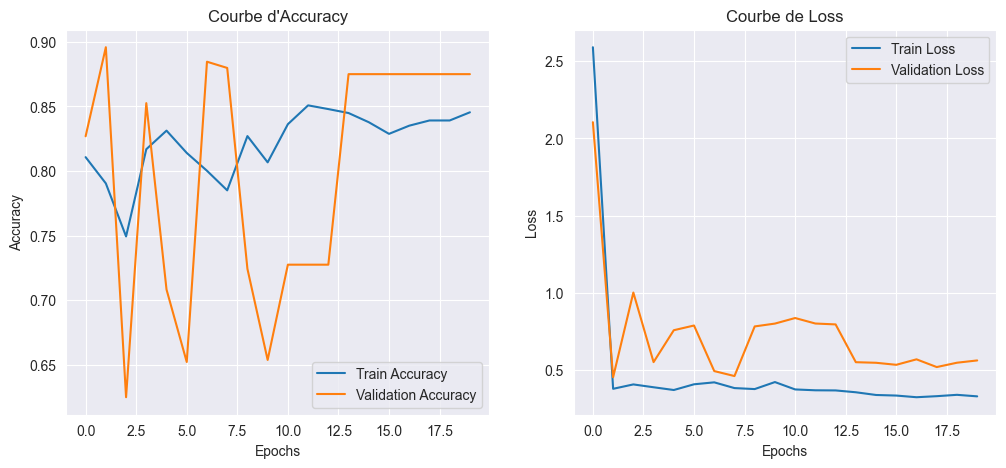

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step


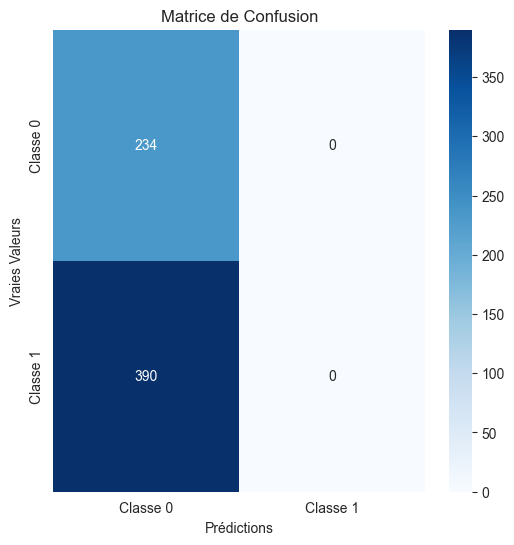

Meilleure précision atteinte : 0.8958
Perte minimale atteinte : 0.4553


In [27]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Nom de l'expérience
experiment_name = "VGG16 Classifier Adaptatif test"
client = mlflow.tracking.MlflowClient()

# Vérifier si l'expérience existe déjà
existing_experiments = client.search_experiments()
experiment_id = None

for exp in existing_experiments:
    if exp.name == experiment_name:
        experiment_id = exp.experiment_id
        break

# Si l'expérience n'existe pas, la créer
if experiment_id is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Expérience '{experiment_name}' créée.")
else:
    print(f"Expérience '{experiment_name}' existante, utilisation de l'ID {experiment_id}.")

# Définir l'expérience active
mlflow.set_experiment(experiment_name)

# Paramètres du modèle
epochs = 20
batch_size = 15
dense_units = 128
dropout_rate = 0.5
target_accuracy = 0.95

# Définition du modèle initial
base_model = model_VGG16
base_model.trainable = False
x = Flatten()(base_model.output)
x = Dense(dense_units, activation="relu")(x)
x = Dropout(dropout_rate)(x)
prediction = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=prediction)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history_data = {"train_accuracy": [], "val_accuracy": [], "train_loss": [], "val_loss": []}

with mlflow.start_run(run_name=f"VGG16 Dynamique {epochs} epochs, {batch_size} batch"):

    for epoch in range(epochs):
        # Entraînement pour une seule époque
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=batch_size, verbose=1)

        # Récupérer la précision de validation
        val_accuracy = history.history["val_accuracy"][0]
        train_accuracy = history.history["accuracy"][0]
        val_loss = history.history["val_loss"][0]
        train_loss = history.history["loss"][0]

        # Sauvegarde des données pour les graphiques
        history_data["train_accuracy"].append(train_accuracy)
        history_data["val_accuracy"].append(val_accuracy)
        history_data["train_loss"].append(train_loss)
        history_data["val_loss"].append(val_loss)

        mlflow.log_metric(f"val_accuracy_epoch_{epoch+1}", val_accuracy)
        mlflow.log_metric(f"train_accuracy_epoch_{epoch+1}", train_accuracy)

        # Vérifier si la performance est inférieure au seuil
        if val_accuracy < target_accuracy:
            dense_units += 64  # Ajout de neurones
            print(f"Ajout de neurones à l'époque {epoch+1}, total neurones : {dense_units}")

            # Ajouter dynamiquement une couche au modèle existant
            new_layer = Dense(dense_units, activation="relu")
            dropout_layer = Dropout(dropout_rate)

            # Transformer le modèle en séquentiel pour ajouter des couches
            model = tf.keras.Sequential([model, new_layer, dropout_layer, Dense(1, activation="sigmoid")])
            model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

        else:
            print(f"Précision atteinte à l'époque {epoch+1}, poursuite sans modification")

    # Évaluation finale sur test
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
    mlflow.log_metric("final_test_accuracy", test_accuracy)
    mlflow.log_metric("final_test_loss", test_loss)

    print(f"Accuracy sur test : {test_accuracy:.4f}")
    print(f"Loss sur test : {test_loss:.4f}")

    # Enregistrement du modèle
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("dense_units_final", dense_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.keras.log_model(model, "VGG16_Dynamique")

# Affichage des courbes de performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_data["train_accuracy"], label="Train Accuracy")
plt.plot(history_data["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Courbe d'Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_data["train_loss"], label="Train Loss")
plt.plot(history_data["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe de Loss")
plt.legend()

plt.show()

# Matrice de confusion
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies Valeurs")
plt.title("Matrice de Confusion")
plt.show()

# Calcul des valeurs maximales et minimales
max_accuracy = max(history_data["val_accuracy"])
min_loss = min(history_data["val_loss"])

print(f"Meilleure précision atteinte : {max_accuracy:.4f}")
print(f"Perte minimale atteinte : {min_loss:.4f}")

# Sauvegarde dans MLflow
mlflow.log_metric("max_validation_accuracy", max_accuracy)
mlflow.log_metric("min_validation_loss", min_loss)


In [ ]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des performances sur l'ensemble de test
print(f"Loss sur les données de test : {test_loss}")
print(f"Accuracy sur les données de test : {test_accuracy}")

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Conversion des probabilités en classes binaires
y_pred_classes = (y_pred > 0.9).astype("int")  # Seuil fixé à 0.9

# Sélectionner uniquement les images prédites comme PNEUMONIE ET qui sont réellement des PNEUMONIA
indices_pneumonia = np.where((y_pred_classes == 1) & (y_test == 1))[0]

# Vérifier si des indices_pneumonia ont été détectés
if len(indices_pneumonia) == 0:
    print("⚠ Aucun cas de pneumonie  détecté avec le seuil actuel.")
else:
    # Mélange aléatoire des indices des PNEUMONIE détectés
    np.random.shuffle(indices_pneumonia)
    indices_a_afficher = indices_pneumonia[:9]  # Sélectionne jusqu'à 9 images aléatoirement

    # Création d'un affichage en grille 3x3 pour montrer quelques images de test et leurs prédictions.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(len(indices_a_afficher)):
        idx = indices_a_afficher[i]
        axes[i].imshow(X_test[idx])  # Affichage de l'image de test
        axes[i].axis("off")

        label = "PNEUMONIA" if y_pred_classes[idx] == 1 else "NORMAL"
        true_label = "PNEUMONIA" if y_test[idx] == 1 else "NORMAL"

        # Affichage du titre de l'image indiquant la prédiction et la réalité.
        axes[i].set_title(f"Prédit : {label} / Réel : {true_label}", fontsize=8)

    # Masquer les cases vides si moins de 9 images sont affichées
    for i in range(len(indices_a_afficher), 9):
        axes[i].axis("off")

    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Récupérer les valeurs de l'historique
epochs = range(1, len(history.history['loss']) + 1)
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Création du graphique
plt.figure(figsize=(10, 5))

# Courbe de la loss
plt.plot(epochs, loss, 'r-', label="Loss (train)")
plt.plot(epochs, val_loss, 'r--', label="Loss (val)")

# Courbe de l'accuracy
plt.plot(epochs, accuracy, 'b-', label="Accuracy (train)")
plt.plot(epochs, val_accuracy, 'b--', label="Accuracy (val)")

# Personnalisation du graphique
plt.xlabel("Époques")
plt.ylabel("Valeurs")
plt.title("Évolution de l'accuracy et du loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Importation de la matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions sur les données de test
y_pred_proba = model.predict(X_test)

# Conversion des probabilités en classes (si softmax ou sigmoid)
y_pred = np.argmax(y_pred_proba, axis=1)  # pour softmax multi-classes
# y_pred = (y_pred_proba > 0.5).astype(int)  # pour binaire (sigmoid)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.title("Matrice de confusion")
plt.show()

In [ ]:
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt
import numpy as np
from mlflow.models import infer_signature

# Extraction des meilleures métriques de l'entraînement
meilleure_accuracy_train = max(history.history["accuracy"])
meilleure_accuracy_val = max(history.history["val_accuracy"])
min_loss = min(history.history["loss"])

# Initialisation du suivi MLflow
mlflow.set_experiment("VGG16 Classifier 1")

with mlflow.start_run(run_name="VGG16 Classifier"):

    # Enregistrement des hyperparamètres
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrement des métriques finales
    mlflow.log_metric("final_train_accuracy", meilleure_accuracy_train)
    mlflow.log_metric("final_val_accuracy", meilleure_accuracy_val)
    mlflow.log_metric("min_loss", min_loss)

    # Enregistrement des métriques par époque
    for epoch, acc in enumerate(history.history["accuracy"]):
        mlflow.log_metric(f"train_accuracy_epoch_{epoch+1}", acc)

    for epoch, val_acc in enumerate(history.history["val_accuracy"]):
        mlflow.log_metric(f"val_accuracy_epoch_{epoch+1}", val_acc)

    for epoch, loss in enumerate(history.history["loss"]):
        mlflow.log_metric(f"train_loss_epoch_{epoch+1}", loss)

    # Enregistrement du modèle
    mlflow.keras.log_model(model, "VGG16_classifier")

    # Génération des graphiques de performance
    # Courbes de perte
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"], label="Train Loss", linestyle="-", marker="s")
    plt.plot(history.history["val_loss"], label="Validation Loss", linestyle="-", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Évolution de la Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    mlflow.log_artifact("loss_plot.png")

    # Courbes de précision
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy", linestyle="--", marker="o")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="--", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Évolution de l'Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.png")
    mlflow.log_artifact("accuracy_plot.png")

    # Graphique combiné (accuracy et loss)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy", linestyle="--", marker="o")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="--", marker="o")
    plt.plot(history.history["loss"], label="Train Loss", linestyle="-", marker="s")
    plt.plot(history.history["val_loss"], label="Validation Loss", linestyle="-", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Évolution de l'Accuracy et de la Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("combined_metrics.png")
    mlflow.log_artifact("combined_metrics.png")

    # Enregistrement de quelques prédictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int")  # Seuil ajusté à 0.5

    # Sélectionner des images pour MLflow
    for i in range(5):
        plt.imshow(X_test[i])
        plt.title(f"Prédit : {y_pred_classes[i]}, Réel : {y_test[i]}")
        plt.axis("off")
        plt.savefig(f"sample_prediction_{i}.png")
        mlflow.log_artifact(f"sample_prediction_{i}.png")


### Mise en place de ResNet50

In [ ]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
image_resize = 224

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Ignore les warnings pour éviter les messages inutiles dans la console.

def get_train_test(base_path: str):  # Définition d'une fonction qui charge et prépare les images à partir d'un dossier.
    X = []  # Liste pour stocker les images.
    y = []  # Liste pour stocker les labels.

    label_map = {"NORMAL": 0, "PNEUMONIA": 1}  # Dictionnaire associant les labels aux classes numériques.

    for label in os.listdir(base_path):  # Parcours des dossiers présents dans le répertoire de base.
        if label not in label_map:  # Vérifie que le dossier correspond bien à une classe attendue
            continue  # Si le label ne fait pas partie des classes définies, il est ignoré.

        label_path = os.path.join(base_path, label)  # Création du chemin vers le dossier contenant les images.

        for file_name in os.listdir(label_path):  # Parcours de chaque fichier dans le dossier.
            file_path = os.path.join(label_path, file_name)  # Obtention du chemin complet de l'image.
            img = cv2.imread(file_path)  # Lecture de l'image avec OpenCV.
            if img is None:  # Vérifie que l'image a bien été chargée.
                continue  # Ignore les fichiers qui ne sont pas des images valides.

            img = cv2.resize(img, (image_resize, image_resize), interpolation=cv2.INTER_CUBIC)  # Redimensionne l'image à la taille souhaitée.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertit l'image du format BGR (OpenCV) à RGB (standard).
            img = img / 255.0  # Normalise les pixels entre 0 et 1 pour améliorer la stabilité du modèle.

            X.append(img)  # Ajoute l'image prétraitée à la liste X.
            y.append(label_map[label])  # Ajoute le label correspondant à la liste y.

    X = np.array(X).reshape(-1, image_resize, image_resize, 3)  # Convertit la liste en tableau NumPy avec la bonne forme (nombre d'images, hauteur, largeur, canaux).
    y = np.array(y).reshape(-1, 1)  # Convertit la liste de labels en tableau NumPy.

    return X, y  # Retourne les tableaux contenant les images et leurs labels.

# Chargement des données d'entraînement et de test.
X_train, y_train = get_train_test("chest_xray/train")  # Charge les images pour l'entraînement.
X_test, y_test = get_train_test("chest_xray/test")  # Charge les images pour le test.

In [ ]:
# Charger le modèle pré-entraîné sans les couches de classification finales
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base pour conserver les poids pré-entraînés
for layer in base_model.layers:
    layer.trainable = False  # On empêche leur entraînement pour éviter d’écraser les connaissances acquises


In [ ]:
# Ajout de couches personnalisées sur le modèle pré-entraîné
x = GlobalAveragePooling2D()(base_model.output)  # Permet de réduire la dimension tout en conservant les informations essentielles
x = Dense(512, activation="relu")(x)  # Couche dense avec activation ReLU pour capter des caractéristiques complexes
x = Dropout(0.3)(x)  # Dropout pour réduire l'overfitting
x = Dense(256, activation="relu")(x)  # Autre couche dense pour approfondir la représentation
x = Dropout(0.3)(x)  # Nouveau dropout pour plus de régularisation
x = Dense(128, activation="relu")(x)  # Couche plus petite pour affiner la structure
x = Dropout(0.2)(x)  # Dernière régularisation pour éviter le sur-apprentissage
output = Dense(1, activation="sigmoid")(x)  # Activation sigmoïde pour une classification binaire

# Définition du modèle final
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Définition de l'optimiseur et de la fonction de perte
optimizer = Adam(learning_rate=0.0005)  # Taux d'apprentissage faible pour assurer une convergence stable
loss_function = "binary_crossentropy"  # Perte adaptée à un problème de classification binaire

# Compilation du modèle
model.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])

In [ ]:
# Définition des paramètres d'entraînement
batch_size = 32  # Taille des lots pour une mise à jour efficace des poids
epochs = 40  # Nombre d'époques pour un entraînement progressif
validation_data = (X_test, y_test)  # Données de validation pour éviter l'overfitting

# Entraînement du modèle
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data)

# Évaluation du modèle après entraînement
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des résultats finaux
print(f"\n🔎 **Résultats après entraînement :**")
print(f"Test Accuracy Maximum : {max(history.history['val_accuracy']) * 100:.2f}%")
print(f"Test Loss Minimum : {min(history.history['val_loss']):.4f}")
print(f"Accuracy sur données de test : {test_accuracy * 100:.2f}%")
print(f"Loss sur données de test : {test_loss:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Récupération des valeurs d'accuracy et de loss
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Création des graphiques
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Courbe d'Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Courbe de Loss")

# Affichage des graphiques
plt.show()

In [ ]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des performances sur l'ensemble de test
print(f"Loss sur les données de test : {test_loss}")
print(f"Accuracy sur les données de test : {test_accuracy}")

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Conversion des probabilités en classes binaires
y_pred_classes = (y_pred > 0.9).astype("int")  # Seuil fixé à 0.9

# Sélectionner uniquement les images prédites comme PNEUMONIE ET qui sont réellement des PNEUMONIA
indices_pneumonia = np.where((y_pred_classes == 1) & (y_test == 1))[0]

# Vérifier si des indices_pneumonia ont été détectés
if len(indices_pneumonia) == 0:
    print("⚠ Aucun cas de pneumonie  détecté avec le seuil actuel.")
else:
    # Mélange aléatoire des indices des PNEUMONIE détectés
    np.random.shuffle(indices_pneumonia)
    indices_a_afficher = indices_pneumonia[:9]  # Sélectionne jusqu'à 9 images aléatoirement

    # Création d'un affichage en grille 3x3 pour montrer quelques images de test et leurs prédictions.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(len(indices_a_afficher)):
        idx = indices_a_afficher[i]
        axes[i].imshow(X_test[idx])  # Affichage de l'image de test
        axes[i].axis("off")

        label = "PNEUMONIA" if y_pred_classes[idx] == 1 else "NORMAL"
        true_label = "PNEUMONIA" if y_test[idx] == 1 else "NORMAL"

        # Affichage du titre de l'image indiquant la prédiction et la réalité.
        axes[i].set_title(f"Prédit : {label} / Réel : {true_label}", fontsize=8)

    # Masquer les cases vides si moins de 9 images sont affichées
    for i in range(len(indices_a_afficher), 9):
        axes[i].axis("off")

    plt.show()


##### modèle Xception

In [ ]:
#Import Os and Basis Libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Directory containing the "Train" folder
directory = "chest_xray/train"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [ ]:
df_train

In [ ]:
# Directory containing the "Train" folder
directory = "chest_xray/test"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [ ]:
df_test.sample(5)

In [ ]:
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

In [ ]:
data_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

IMAGE_SIZE = (256,256)

print('Training Images:')
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

#Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

In [ ]:
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

# Encode Labels

# Define your class labels
class_labels = ['NORMAL', 'PNEUMONIA']

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the class labels
label_encoder.fit(class_labels)

# Transform the labels for training dataset
train_labels_encoded = label_encoder.transform(train_labels)

# Transform the labels for validation dataset
validation_labels_encoded = label_encoder.transform(validation_labels)

# Transform the labels for test dataset
test_labels_encoded = label_encoder.transform(test_labels)

In [ ]:
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

In [ ]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
# Val Data
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
# Test Data
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

In [ ]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count par Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
count = df_test['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution par Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Nombres par Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)

    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))

    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')

    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

In [ ]:
#### Images Normal sans pneumonie
path_to_visualize = "chest_xray/train/NORMAL"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [ ]:
#### Images Pneumonia avec pneumonie
path_to_visualize = "chest_xray/train/PNEUMONIA"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [ ]:
from keras.src.applications.xception import Xception

# Load the Xception base model without the top (classification) layer
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Build Model
model = Sequential()

# Base Model
model.add(base_model)

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.45))

# Dense Layer 1
model.add(Dense(220, activation='relu'))

# Dropout Layer
model.add(Dropout(0.25))

# Dense Layer 2
model.add(Dense(60,activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Fitting Model
history = model.fit(
        train_ds,
        epochs= 20,
        validation_data = validation_ds,
        callbacks = early_stopping)

In [ ]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

In [ ]:
# Évaluation du modèle sur le dataset de test
test_loss, test_accuracy = model.evaluate(test_ds)

# Affichage des résultats en pourcentage
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
# Trouver le numéro de la meilleure époque (epoch) où la précision de validation est maximale
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Définir le style de fond pour les graphiques
plt.style.use('ggplot')  # Utilisation d'un style valide pour matplotlib

# Création d'une figure avec 2 sous-graphiques (subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# 📊 Tracé de la précision (accuracy) en entraînement et en validation
axs[0].plot(history.history['accuracy'], label='Précision Entraînement', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Précision Validation', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green',
               label=f'Meilleure époque : {best_epoch}')  # Marquage du meilleur epoch
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Précision')
axs[0].set_title('Précision en entraînement et validation')
axs[0].legend()  # Affichage de la légende

# 📉 Tracé de la perte (loss) en entraînement et en validation
axs[1].plot(history.history['loss'], label='Perte Entraînement', color='blue')
axs[1].plot(history.history['val_loss'], label='Perte Validation', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',
               label=f'Meilleure époque : {best_epoch}')  # Marquage du meilleur epoch
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perte')
axs[1].set_title('Perte en entraînement et validation')
axs[1].legend()  # Affichage de la légende

# 📏 Ajustement de la mise en page pour éviter le chevauchement
plt.tight_layout()

# 🖼️ Affichage du graphique final
plt.show()


In [ ]:
# Définition du chemin vers le dossier contenant les images de test
test_dir = 'chest_xray/test/'
print('Chargement des images de test...')

# Chargement du dataset d'images depuis le dossier spécifié
# - `seed=123` assure que les images sont toujours chargées dans le même ordre
# - `image_size=IMAGE_SIZE` redimensionne toutes les images à la taille souhaitée
# - `batch_size=32` définit le nombre d'images traitées simultanément
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(256, 256),  # Assurez-vous que IMAGE_SIZE est bien défini
    batch_size=32
)

# Définition d'une fonction pour afficher les images avec leurs prédictions
def plot_images_with_predictions(model, dataset, class_labels, num_images=20, num_images_per_row=5):
    """
    Cette fonction affiche un ensemble d'images avec leur **classe réelle** et **classe prédite**.
    Elle prend :
    - `model` : Le modèle de deep learning entraîné
    - `dataset` : Le dataset contenant les images à prédire
    - `class_labels` : Les noms des classes (ex: ['NORMAL', 'PNEUMONIA'])
    - `num_images` : Le nombre total d'images à afficher
    - `num_images_per_row` : Nombre d'images par ligne pour la mise en forme
    """

    # Vérifier que le dataset contient suffisamment d'images
    dataset_list = list(dataset.as_numpy_iterator())  # Convertir le dataset en liste
    if len(dataset_list) == 0:
        print("Erreur : le dataset est vide !")
        return

    # Mélange le dataset pour éviter l'ordre fixe
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset_list))

    # Génération des prédictions
    predictions = model.predict(dataset_shuffled.take(num_images))

    # Création de la figure pour afficher les images
    plt.figure(figsize=(15, 10))

    img_counter = 0  # Compteur pour suivre le nombre d'images affichées

    for images, labels in dataset_shuffled.take(num_images):
        images = images.numpy()  # Convertir Tensor en NumPy

        for j in range(len(images)):  # Parcours des images dans le batch
            if img_counter < num_images:  # S'assurer que l'on ne dépasse pas le nombre d'images souhaité
                predicted_class = class_labels[np.argmax(predictions[img_counter])]
                true_class = class_labels[np.argmax(labels[j])]

                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, img_counter + 1)
                plt.imshow(images[j].astype("uint8"))
                plt.title(f'Réel: {true_class}\nPrédit: {predicted_class}')
                plt.axis('off')

                img_counter += 1  # Incrémenter le compteur

    plt.tight_layout()
    plt.show()

# Affichage des images avec leurs prédictions
print('Affichage des prédictions sur 20 images aléatoires du dataset de test...')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)


In [ ]:
# Path to the directory containing the images
directory_path = 'chest_xray/test/PNEUMONIA/'

# Select N image files from the directory
image_files = os.listdir(directory_path)[:5]

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

# Load and preprocess each image, make predictions, and display them using a loop
for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    # Resize the image to (256, 256)
    img = cv2.resize(img, (256, 256))

    # Normalize pixel values
    img_array = img.astype(np.float32) / 255.0

    # Expand the dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    # Display the image with predicted label
    # Convert BGR to RGB for displaying with matplotlib
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

# Adjust layout
plt.tight_layout()
plt.show()